In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec
import re
import seaborn as sns
import matplotlib.pyplot as plt


C:\Anaconda3\envs\tf_gpu1\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
df = pd.read_csv('Top30.csv')
df =df.drop(['Unnamed: 0','Unnamed: 0.1'],axis =1)
df = df[pd.notnull(df['Description'])]
df.head(10)

,Query,Description
0,Administrative Assistant,This Administrative Assistant position is resp...
1,Administrative Assistant,ADMINISTRATIVE ASSISTANT Part Time The West Or...
2,Administrative Assistant,Administrative Assistant - In Bus 26yrs Fashi...
3,Sales Representative,Are you ready for something new? Are you tired...
4,Customer Service Representative,Superior Staff Resources is currently seeking ...
5,Customer Service Representative,<br />\r<span><strong>The Opportunity:</strong...
6,Java Developer,<P><STRONG>As a member of the Web and Portal D...
7,Java Developer,<BR>\r<TABLE border=0 cellSpacing=0 cellPaddin...
8,Administrative Assistant,The main function of this role is to provide a...
9,Financial Analyst,Financial Analyst\n Perform portfolio analysis...


In [3]:
df.shape

(72292, 2)

In [4]:
df.index = range(72292)
df['Description'].apply(lambda x: len(x.split(' '))).sum()

19061303

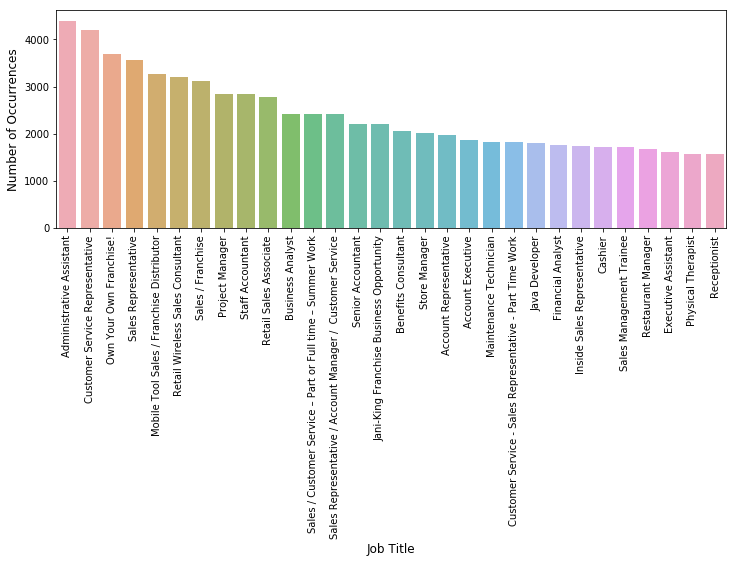

In [5]:
#Exploring
cnt_pro = df['Query'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Job Title', fontsize=12)
plt.xticks(rotation=90)
plt.show();

In [7]:
def print_complaint(index):
    example = df[df.index == index][['Description', 'Query']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Query:', example[1])
        


In [8]:
print_complaint(12)

<p>GC Services, a top performer in the Teleservices and Collections industry, is seeking sales driven individuals to join our Business Development team at our Houston, TX and Elgin, IL locations. </p>\r<p>&nbsp;</p>\r<p>The ideal candidates will possess an entrepreneurial spirit and drive to sell the company as a top provider of call center solutions and executing sales strategies that result in securing service contracts.</p>\r<p>&nbsp;</p>\r<p><strong>Essential Duties and Responsibilities </strong>include the following. Other duties may be assigned. </p>\r<p>&nbsp;</p>\r<ul>\r    <li>Generate leads through cold calling, networking and leveraging existing contact base.</li>\r    <li>Performs sales presentations to prospective clients.</li>\r    <li>Interacts with existing customers to increase sales of services.</li>\r    <li>Research and gather data on marketing trends, competitive services and pricing.</li>\r    <li>Build, manage and optimize B2B relationships</li>\r    <li>Utilize 

In [9]:
print_complaint(20)

Project Manager Job  \r\n<p>An Engineering & Construction Firm in Birmingham, AL is seeking a Sr. BIM Manager / VDC Integration Specialist for an immediate direct hire opportunity to lead multiple healthcare facility construction projects. The right candidate will have 5-10 years experience in Virtual Construction Integration using Navisworks Manage. </p><p><b>Responsibilities</b></p><ul><li>Lead teams to successful BIM construction collaboration efforts to include Construction Sequencing, data mining from the BIM models and costing/post construction </li><li>Coordinate with Architects, Engineers, subcontractors in the pre-construction and construction phase</li><li>Some creation or modification of BIM drawing as needed</li><li>Face to face client interaction</li></ul><p><b>Requirements</b></p><ul><li>Associates in Building Science, Construction Management, Civil Engineering, Architecture or related experience, Bachelors degree preferred</li><li>5+ years experience with BIM Technology 

In [10]:
#Text Preprocessing
from bs4 import BeautifulSoup
def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text
df['Description'] = df['Description'].apply(cleanText)

C:\Anaconda3\envs\tf_gpu1\lib\site-packages\bs4\__init__.py:272: UserWarning: "b'TEST'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Anaconda3\envs\tf_gpu1\lib\site-packages\bs4\__init__.py:272: UserWarning: "b'TEST'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Anaconda3\envs\tf_gpu1\lib\site-packages\bs4\__init__.py:272: UserWarning: "b'TEST'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Anaconda3\envs\tf_gpu1\lib\site-packages\bs4\__init__.py:272: UserWarning: "b'TEST'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Anaconda3\envs\tf_gpu1\lib\site-packages\bs4\__init__.py:272:

In [11]:
train, test = train_test_split(df, test_size=0.3, random_state=42)

In [12]:
import nltk
from nltk.corpus import stopwords
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

In [13]:
train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['Description']), tags=[r.Query]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['Description']), tags=[r.Query]), axis=1)

In [14]:
train_tagged.values[30]

TaggedDocument(words=['becker', 'underwood', 'inventing', 'the', 'future™', '\\r\\r\\rbecker', 'underwood', 'is', 'global', 'leader', 'in', 'seed', 'enhancements', 'landscape', 'horticulture', 'and', 'agriculture', 'our', 'products', 'are', 'marketed', 'all', 'over', 'the', 'world', 'in', '82', 'countries', 'since', 'our', 'founding', 'in', '1982', 'we', 'have', 'eperienced', 'tremendous', 'growth', 'through', 'product', 'development', 'and', 'acquisitions', 'we', 'currently', 'seek', '\\rreceptionist', '\\rthis', 'position', 'will', 'provide', 'professional', 'and', 'efficient', 'customer', 'service', 'on', 'the', 'phone', 'and', 'in', 'person', 'and', 'provide', 'administrative', 'support', 'to', 'internal', 'customers', '\\rprincipal', 'accountabilities', '\\rcustomer', 'service\\r\\r', 'answer', 'multi-line', 'telephone', 'and', 'transfer', 'as', 'required.\\r', 'greet', 'visitors', 'log', 'information', 'into', 'visitor', 'log', 'and', 'coordinate', 'escort.\\r', 'these', 'duties'

In [15]:
import multiprocessing
cores = multiprocessing.cpu_count()

In [16]:
#Building a Vocabulary
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|███████████████████████████████████████████████████████████████████████| 50604/50604 [00:00<00:00, 2984708.06it/s]


In [17]:
%%time
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|███████████████████████████████████████████████████████████████████████| 50604/50604 [00:00<00:00, 1751630.41it/s]


Wall time: 2min 41s


In [18]:
#Building the Final Vector Feature for the Classifier
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [19]:
#Train the Logistic Regression Classifier.
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)

In [20]:
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

C:\Anaconda3\envs\tf_gpu1\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\envs\tf_gpu1\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [21]:
from sklearn.metrics import accuracy_score, f1_score
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.9034028033935817
Testing F1 score: 0.9031240269775418


In [22]:
#Distributed Memory (DM)
model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)
model_dmm.build_vocab([x for x in tqdm(train_tagged.values)])

100%|███████████████████████████████████████████████████████████████████████| 50604/50604 [00:00<00:00, 3382770.62it/s]


In [23]:
%%time
for epoch in range(30):
    model_dmm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dmm.alpha -= 0.002
    model_dmm.min_alpha = model_dmm.alpha

100%|███████████████████████████████████████████████████████████████████████| 50604/50604 [00:00<00:00, 2812021.35it/s]


Wall time: 3min 53s


In [24]:
#Train the Logistic Regression Classifier
y_train, X_train = vec_for_learning(model_dmm, train_tagged)
y_test, X_test = vec_for_learning(model_dmm, test_tagged)

In [25]:
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

C:\Anaconda3\envs\tf_gpu1\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\envs\tf_gpu1\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Testing accuracy 0.1383253412025083
Testing F1 score: 0.1161899573160096


In [26]:
#Model Pairing First, we delete temporary training data to free up RAM.
model_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
model_dmm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

In [27]:
#Concatenate two models.
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec
new_model = ConcatenatedDoc2Vec([model_dbow, model_dmm])

In [28]:
#Building feature vectors.
def get_vectors(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [29]:
#Train the Logistic Regression
y_train, X_train = get_vectors(new_model, train_tagged)
y_test, X_test = get_vectors(new_model, test_tagged)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

C:\Anaconda3\envs\tf_gpu1\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Anaconda3\envs\tf_gpu1\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Anaconda3\envs\tf_gpu1\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Testing accuracy 0.8791036517890077
Testing F1 score: 0.8787076378900566


In [37]:
df_X_train = pd.DataFrame(list(X_train))

In [39]:
df_X_test = pd.DataFrame(list(X_test))

In [40]:
df_X_train['target'] = list(y_train)
df_X_test['target'] = list(y_test)

In [42]:
df_X_train.to_csv('trainingData.csv')
df_X_test.to_csv('testingData.csv')